### 1. Import libraries, read Cryptocurrency data from CoinGecko API, and convert to usable DataFrame.

In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import PolynomialFeatures

url_pre = 'https://api.coingecko.com/api/v3/coins/'
url_suf = '/market_chart?vs_currency=usd&days=150'
coins = ['bitcoin', 'ethereum', 'ripple', 'bitcoin-cash', 'eos', 'stellar', 'litecoin']
list_of_dfs = []
for coin in coins:
    url = url_pre + coin + url_suf
    result = requests.get(url)
    j = result.json()
    prices = j['prices']
    prices_df = pd.DataFrame(prices, columns=['TimeStamp', '{} Price'.format(coin)])
    prices_df['TimeStamp'] = pd.to_datetime(prices_df['TimeStamp'], unit='ms').dt.round('1min')
    list_of_dfs.append(prices_df)
    

merged_df = pd.merge(list_of_dfs[0], list_of_dfs[1], how='left', on='TimeStamp')

for i in range(2, len(list_of_dfs)):
    merged_df = merged_df.merge(list_of_dfs[i], how='left', on='TimeStamp')
    
merged_df.tail()

,TimeStamp,bitcoin Price,ethereum Price,ripple Price,bitcoin-cash Price,eos Price,stellar Price,litecoin Price
146,2019-01-24 00:00:00,3555.700003,116.416020,0.314888,131.368101,2.413453,0.101084,31.681310
147,2019-01-25 00:00:00,3565.642005,116.245436,0.315710,128.174275,2.427529,0.101173,32.494779
148,2019-01-26 00:00:00,3564.822417,115.149906,0.313873,126.778764,2.429757,0.100017,32.681209
149,2019-01-27 00:00:00,3563.614563,115.337167,0.312733,125.542903,2.411990,0.098569,32.884245
150,2019-01-27 18:23:00,3557.559104,113.980448,0.308243,NaN,NaN,0.096332,32.621332


### 2. Create function that applies all selected featured engineering changes to any DataFrame used for the model.
- first create function that extracts bitcoin-related community data (e.g. average number of reddit comments, number of twitter followers) from another CoinGecko API, then incorporate that function into `apply_changes()`.

In [3]:
def get_btc_community_data(dataframe, feat1, feat2, feat3, feat4):
        url2_pre = 'https://api.coingecko.com/api/v3/coins/bitcoin/history?date='

        #extract TimeStamps, convert to strings, reverse order, and append to a list.
        timestamps = dataframe['TimeStamp'].values
        str_dates = []
        dates1 = pd.date_range(timestamps[0], timestamps[-1]).round("1d")
        dates2 = dates1.strftime('%d-%m-%Y')
        dates2 = dates2.astype(str)
        date_list = dates2.tolist()
        date_list
          
        feat1_data = []
        feat2_data = []
        feat3_data = []
        feat4_data = []
    
        for date in date_list:  
            url2 = url2_pre + date
            info = requests.get(url2)
            j2 = info.json()
            time = pd.to_datetime(date)
          
            f1 = j2['community_data'][feat1]
            f2 = j2['community_data'][feat2]
            f3 = j2['community_data'][feat3]
            f4 = j2['community_data'][feat4]
            
            try:
                feat1_data.append([time, f1])
            except:
                feat1_data.append([time, np.nan])
            try:
                feat2_data.append([time, f2])
            except:
                feat2_data.append([time, np.nan])
            try:
                feat3_data.append([time, f3])
            except:
                feat3_data.append([time, np.nan])
            try:
                feat4_data.append([time, f4])
            except:
                feat4_data.append([time, np.nan])

        f1_df = pd.DataFrame(feat1_data, columns=['TimeStamp', '{}'.format(feat1)])
        f2_df = pd.DataFrame(feat2_data, columns=['TimeStamp', '{}'.format(feat2)])
        f3_df = pd.DataFrame(feat3_data, columns=['TimeStamp', '{}'.format(feat3)])
        f4_df = pd.DataFrame(feat4_data, columns=['TimeStamp', '{}'.format(feat4)])
        
        list_of_dfs = [f1_df, f2_df, f3_df, f4_df]
        
        merged_feat_df = pd.merge(list_of_dfs[0], list_of_dfs[1], how='left', on='TimeStamp')
        
        for i in range(2, len(list_of_dfs)):
            merged_feat_df = merged_feat_df.merge(list_of_dfs[i], how='left', on='TimeStamp')
            
        a = dataframe.merge(merged_feat_df, how='left', on='TimeStamp')
       
        return a

def apply_changes(dataframe):
    a = dataframe.copy()
    a.dropna(inplace=True)
      
    a = get_btc_community_data(a,
                           'reddit_average_posts_48h',
                           'reddit_average_comments_48h',
                           'facebook_likes',
                           'twitter_followers')
     
    a = a.interpolate(method='linear')
    
    fb_col = a['facebook_likes']
    tw_col = a['twitter_followers']
    fb_delta = fb_col - fb_col.shift(1)
    tw_delta = tw_col - tw_col.shift(1)
    a['fb_likes_diff'] = fb_delta
    a['tw_followers_diff'] = tw_delta
    
    #scale data
    #except for bitcoin Price, since this is eventually going to be the prediction/output
    features_to_scale = [
                        'ethereum Price',
                        'ripple Price',
                        'bitcoin-cash Price',
                        'eos Price',
                        'stellar Price',
                        'litecoin Price',
                        'reddit_average_posts_48h',
                        'reddit_average_comments_48h',
                        'facebook_likes',
                        'twitter_followers',
                        'fb_likes_diff',
                        'tw_followers_diff'
                        ]
    
    a.dropna(inplace=True)
    for feature in features_to_scale:
        m = MinMaxScaler()
        X = a[feature].values.reshape(-1, 1)
        m.fit(X)
        MinMaxScaler(copy=True, feature_range=(0,1))
        a[feature] = m.transform(X)
        #the above line actually permanently replaces the column with its scaled version
     
    #phase-shift all features, this time including the bitcoin Price data
    features_to_shift = [
                        'bitcoin Price',
                        'ethereum Price',
                        'ripple Price',
                        'bitcoin-cash Price',
                        'eos Price',
                        'stellar Price',
                        'litecoin Price',
                        'reddit_average_posts_48h',
                        'reddit_average_comments_48h',
                        'facebook_likes',
                        'twitter_followers',
                        'fb_likes_diff',
                        'tw_followers_diff'
                        ]
    
    for feature in features_to_shift:
        a['{} - 1d'.format(feature)] = a['{}'.format(feature)].shift(1)
        a['{} - 2d'.format(feature)] = a['{}'.format(feature)].shift(2)
    
    a.dropna(inplace=True)
    #just to be safe
        
    return a
    
training_data = apply_changes(merged_df)
training_data.head()

,TimeStamp,bitcoin Price,ethereum Price,ripple Price,bitcoin-cash Price,eos Price,stellar Price,litecoin Price,reddit_average_posts_48h,reddit_average_comments_48h,...,reddit_average_comments_48h - 1d,reddit_average_comments_48h - 2d,facebook_likes - 1d,facebook_likes - 2d,twitter_followers - 1d,twitter_followers - 2d,fb_likes_diff - 1d,fb_likes_diff - 2d,tw_followers_diff - 1d,tw_followers_diff - 2d
3,2018-09-03,7305.272801,0.994994,0.248029,1.000000,0.989875,0.694065,0.967539,0.427165,0.294877,...,0.305472,0.316067,0.006793,0.000000,0.024066,0.000000,0.231338,0.231338,0.202454,0.202454
4,2018-09-04,7260.897517,0.967935,0.226317,0.962864,0.959574,0.671965,0.948870,0.429240,0.284282,...,0.294877,0.305472,0.013587,0.006793,0.048132,0.024066,0.231338,0.231338,0.202454,0.202454
5,2018-09-05,7359.462993,0.952042,0.210764,0.959732,0.959979,0.729294,1.000000,0.431316,0.273688,...,0.284282,0.294877,0.020380,0.013587,0.072198,0.048132,0.231338,0.231338,0.202454,0.202454
6,2018-09-06,6764.926774,0.702396,0.055485,0.791876,0.707375,0.596872,0.806327,0.433391,0.263093,...,0.273688,0.284282,0.027174,0.020380,0.096264,0.072198,0.231338,0.231338,0.202454,0.202454
7,2018-09-07,6498.279613,0.687194,0.118489,0.770822,0.708003,0.597235,0.770372,0.435467,0.252498,...,0.263093,0.273688,0.033967,0.027174,0.120330,0.096264,0.231338,0.231338,0.202454,0.202454


### 3. Visualize Data
- Comment / uncomment to toggle features to plot.

Text(0,0.5,'Price(USD)')

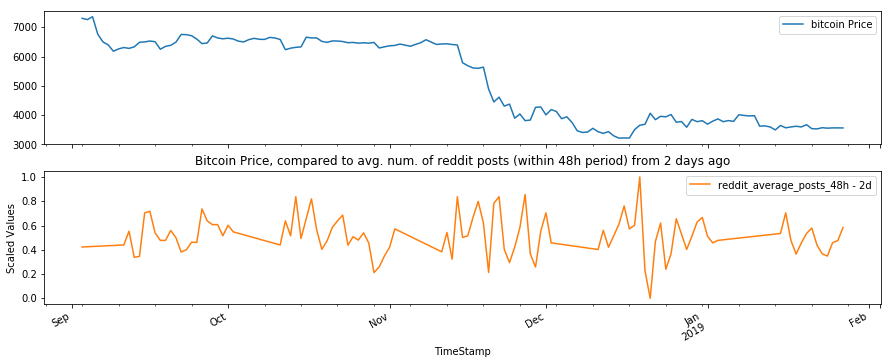

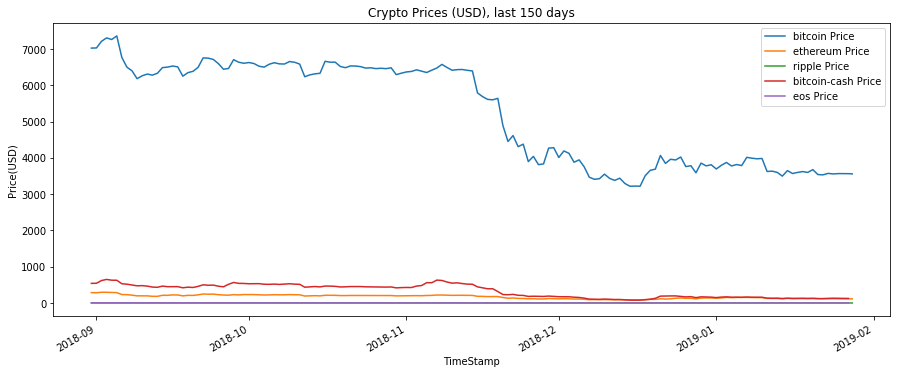

In [4]:
features_to_plot = [ 
                    'bitcoin Price', 
#                     'bitcoin Price - 1d',
#                     'bitcoin Price - 2d', 
#                     'ethereum Price - 1d', 
#                     'ethereum Price - 2d', 
#                     'ripple Price - 1d', 
#                     'ripple Price - 2d', 
#                     'bitcoin-cash Price - 1d',
#                     'bitcoin-cash Price - 2d', 
#                     'eos Price - 1d', 
#                     'eos Price - 2d',
#                     'stellar Price - 1d', 
#                     'stellar Price - 2d', 
#                     'litecoin Price - 1d',
#                     'litecoin Price - 2d', 
#                     'reddit_average_posts_48h - 1d', 
                    'reddit_average_posts_48h - 2d', 
#                     'reddit_average_comments_48h - 1d',
#                     'reddit_average_comments_48h - 2d', 
#                     'facebook_likes - 1d',
#                     'facebook_likes - 2d', 
#                     'twitter_followers - 1d',
#                     'twitter_followers - 2d', 
#                     'fb_likes_diff - 1d', 
#                     'fb_likes_diff - 2d',
#                     'tw_followers_diff - 1d', 
#                     'tw_followers_diff - 2d'
                    ]
    
training_data.plot(x ='TimeStamp',
               y = features_to_plot,
               figsize = (15,6),
                   subplots=True
                  )

days = url_suf[-3:]
plt.title('Bitcoin Price, compared to avg. num. of reddit posts (within 48h period) from 2 days ago')
plt.xlabel('TimeStamp')
plt.ylabel('Scaled Values')

merged_df.plot(x ='TimeStamp',
               y = ['bitcoin Price',
                    'ethereum Price',
                    'ripple Price',
                    'bitcoin-cash Price',
                    'eos Price'],
               figsize = (15,6)
              )

plt.title('Crypto Prices (USD), last {} days'.format(days))
plt.xlabel('TimeStamp')
plt.ylabel('Price(USD)')

### 4. Observe any correlations between bitcoin price and all other considered features.

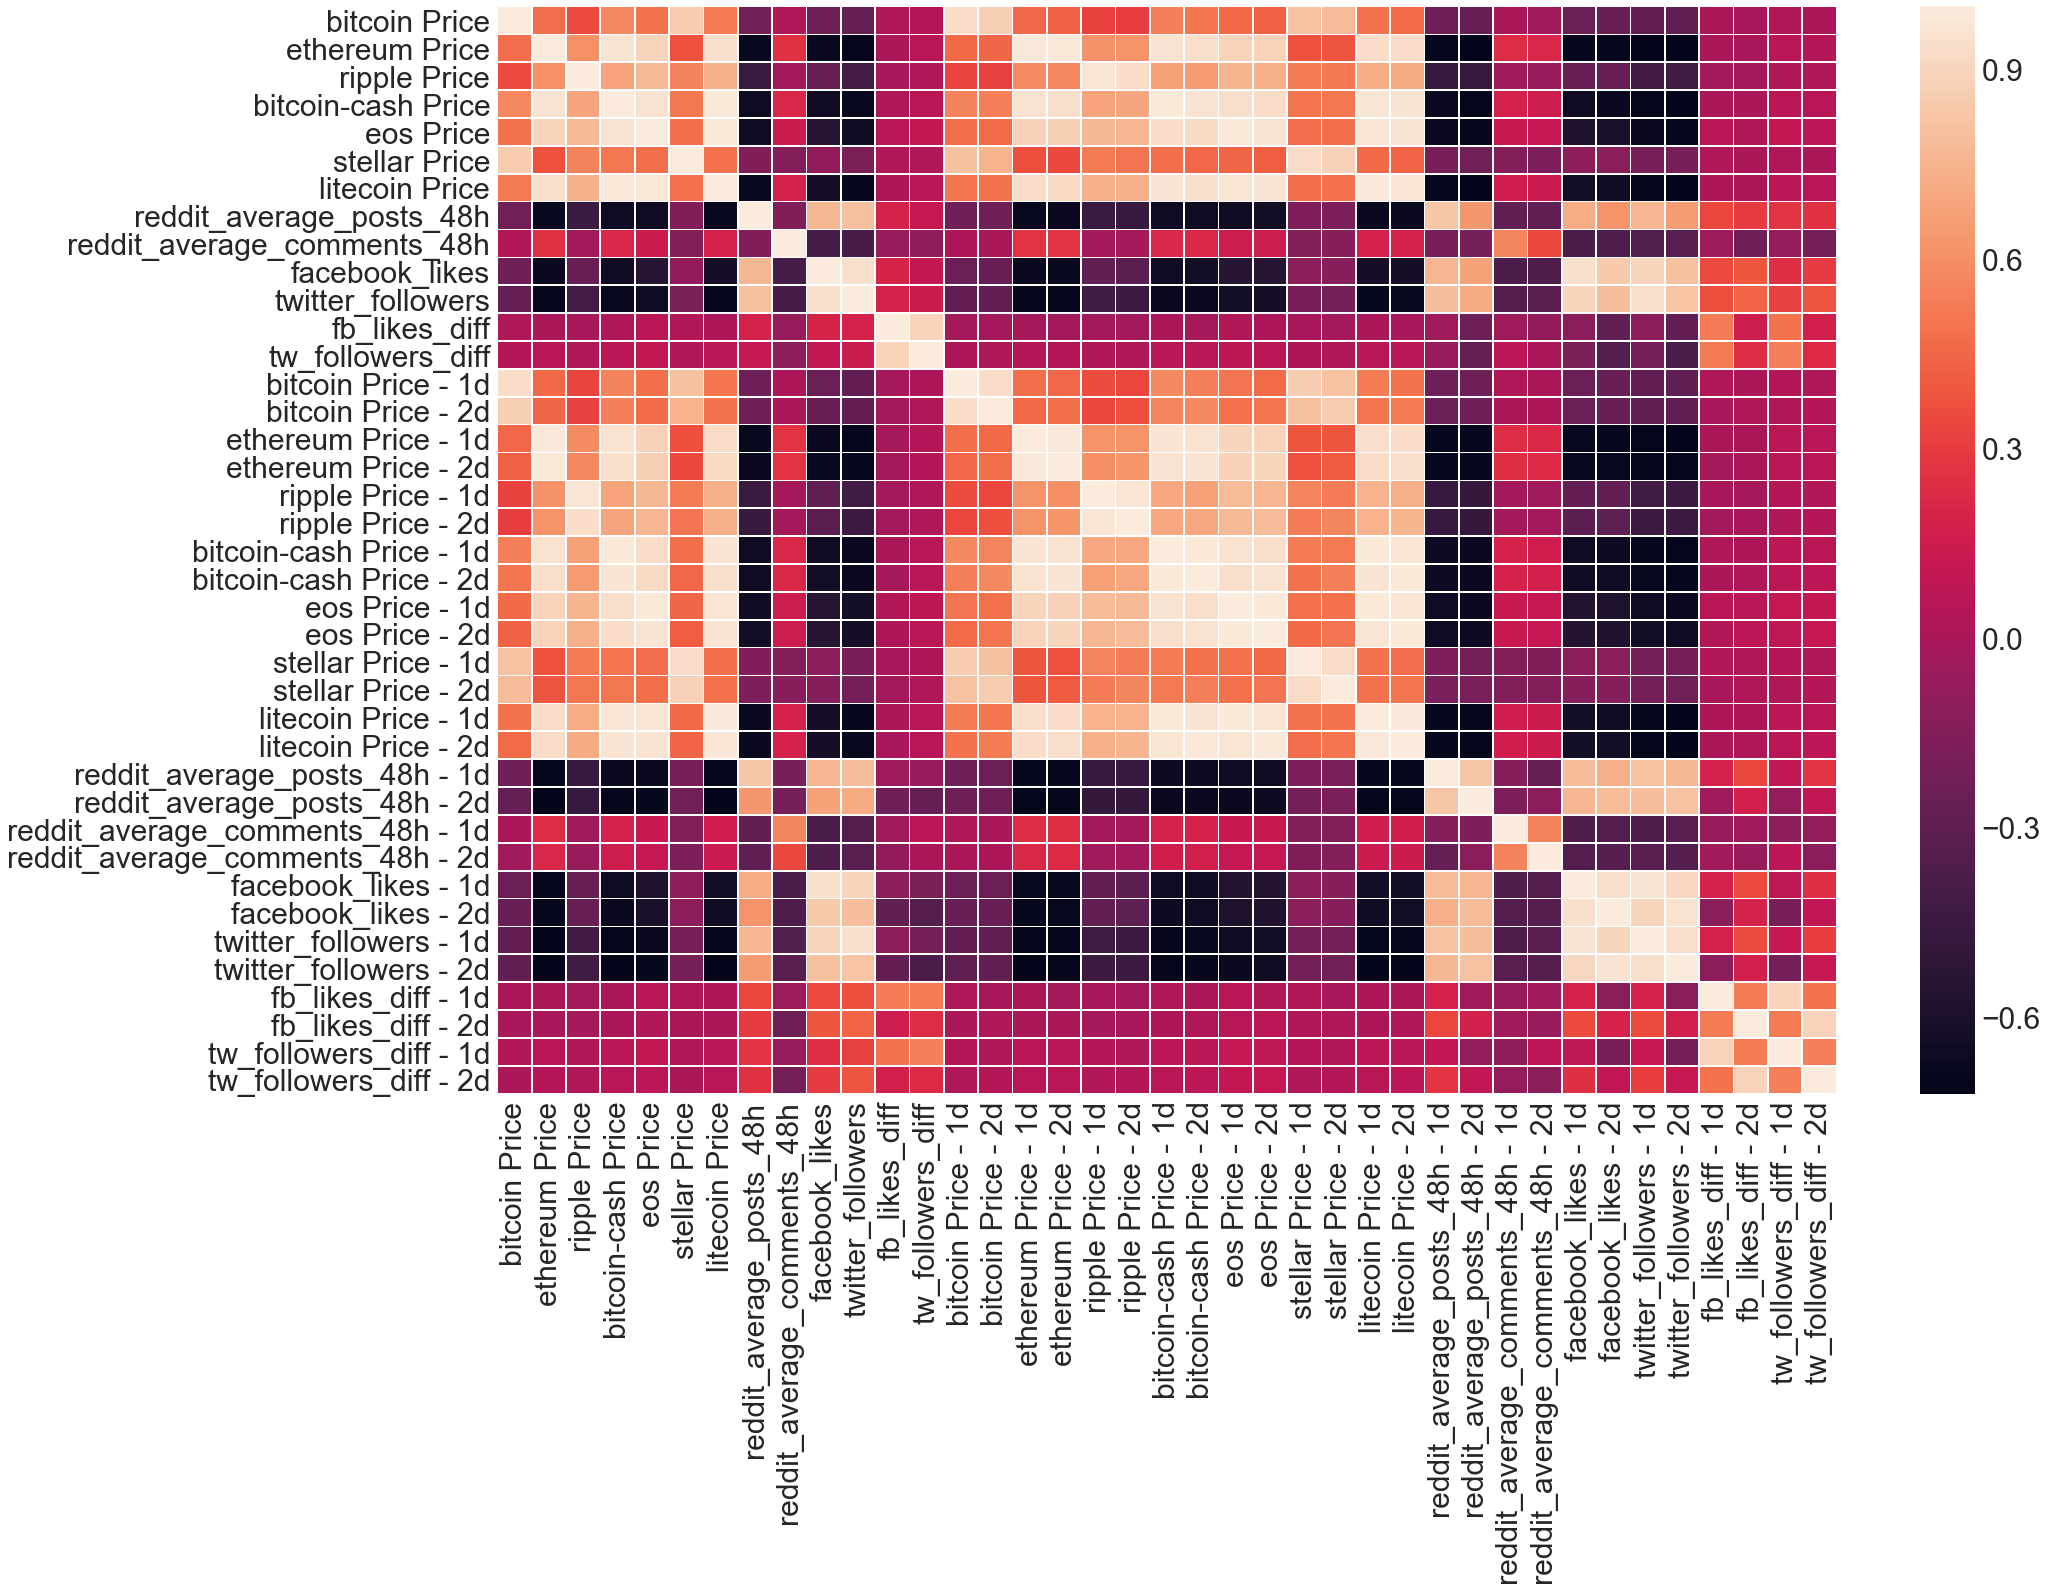

In [4]:
correlation = training_data.corr()
plt.figure(figsize=(30, 20))
sns.set(font_scale=3)
sns.heatmap(correlation, 
            xticklabels=correlation.columns.values, 
            yticklabels=correlation.columns.values, 
            annot = False,
            linewidths=.7)

### 5. Create test data set
- add 2 more rows for the future days
- populate future data with the -2day offset features from the previous 2 days.

### NOTE: A much more in-depth explanation for the code below is described in the separate Jupyter Notebook file:
- `MakingPredictionsWithModelDemo.ipynb`

In [5]:
dummy_rows = pd.DataFrame(np.zeros(shape=(2,len(training_data.columns))),
                          columns=training_data.columns)

dfs_to_concat = [training_data, dummy_rows]
training_and_testing = pd.concat(dfs_to_concat)

t = merged_df['TimeStamp'].values

training_and_testing.iat[-2, 0] = pd.to_datetime(t[-2]) + pd.DateOffset(days=1, minutes=1080)
training_and_testing.iat[-1, 0] = pd.to_datetime(t[-2]) + pd.DateOffset(days=2, minutes=1080)

features_to_shift = [
                     'bitcoin Price', 
                     'ethereum Price', 
                     'ripple Price',
                     'bitcoin-cash Price', 
                     'eos Price', 
                     'stellar Price', 
                     'litecoin Price',
                     'reddit_average_posts_48h', 
                     'reddit_average_comments_48h',
                     'facebook_likes', 
                     'twitter_followers', 
                     'fb_likes_diff',
                     'tw_followers_diff'
                    ]

features_to_fit = [
                    'bitcoin Price - 2d',
                    'ethereum Price - 2d', 
                    'ripple Price - 2d', 
                    'bitcoin-cash Price - 2d', 
                    'eos Price - 2d', 
                    'stellar Price - 2d', 
                    'litecoin Price - 2d', 
                    'reddit_average_posts_48h - 2d', 
                    'reddit_average_comments_48h - 2d',
                    'facebook_likes - 2d', 
                    'twitter_followers - 2d',  
                    'fb_likes_diff - 2d',
                    'tw_followers_diff - 2d'
                    ]

all_model_features = [
                    'TimeStamp',
                    'bitcoin Price',
                    'bitcoin Price - 2d',
                    'ethereum Price - 2d', 
                    'ripple Price - 2d', 
                    'bitcoin-cash Price - 2d', 
                    'eos Price - 2d', 
                    'stellar Price - 2d', 
                    'litecoin Price - 2d', 
                    'reddit_average_posts_48h - 2d', 
                    'reddit_average_comments_48h - 2d',
                    'facebook_likes - 2d', 
                    'twitter_followers - 2d',  
                    'fb_likes_diff - 2d',
                    'tw_followers_diff - 2d'
                    ]

for i in features_to_shift:
    training_and_testing.at[0, '{} - 2d'.format(i)] = training_and_testing.at[148, i]
    training_and_testing.at[1, '{} - 2d'.format(i)] = training_and_testing.at[149, i]
    
testing_data = training_and_testing.iloc[-2:][all_model_features]
testing_data

,TimeStamp,bitcoin Price,bitcoin Price - 2d,ethereum Price - 2d,ripple Price - 2d,bitcoin-cash Price - 2d,eos Price - 2d,stellar Price - 2d,litecoin Price - 2d,reddit_average_posts_48h - 2d,reddit_average_comments_48h - 2d,facebook_likes - 2d,twitter_followers - 2d,fb_likes_diff - 2d,tw_followers_diff - 2d
0,2019-01-28 18:00:00,0.0,3564.822417,0.148041,0.157457,0.087088,0.141892,0.027457,0.215656,0.420938,0.220323,0.998981,0.244473,0.216639,0.148383
1,2019-01-29 18:00:00,0.0,3563.614563,0.148925,0.153870,0.084928,0.138293,0.019724,0.220209,0.402693,0.214216,1.000000,0.244473,0.216639,0.165963


### 6. Instantiate linear regression model and fit it on training data.

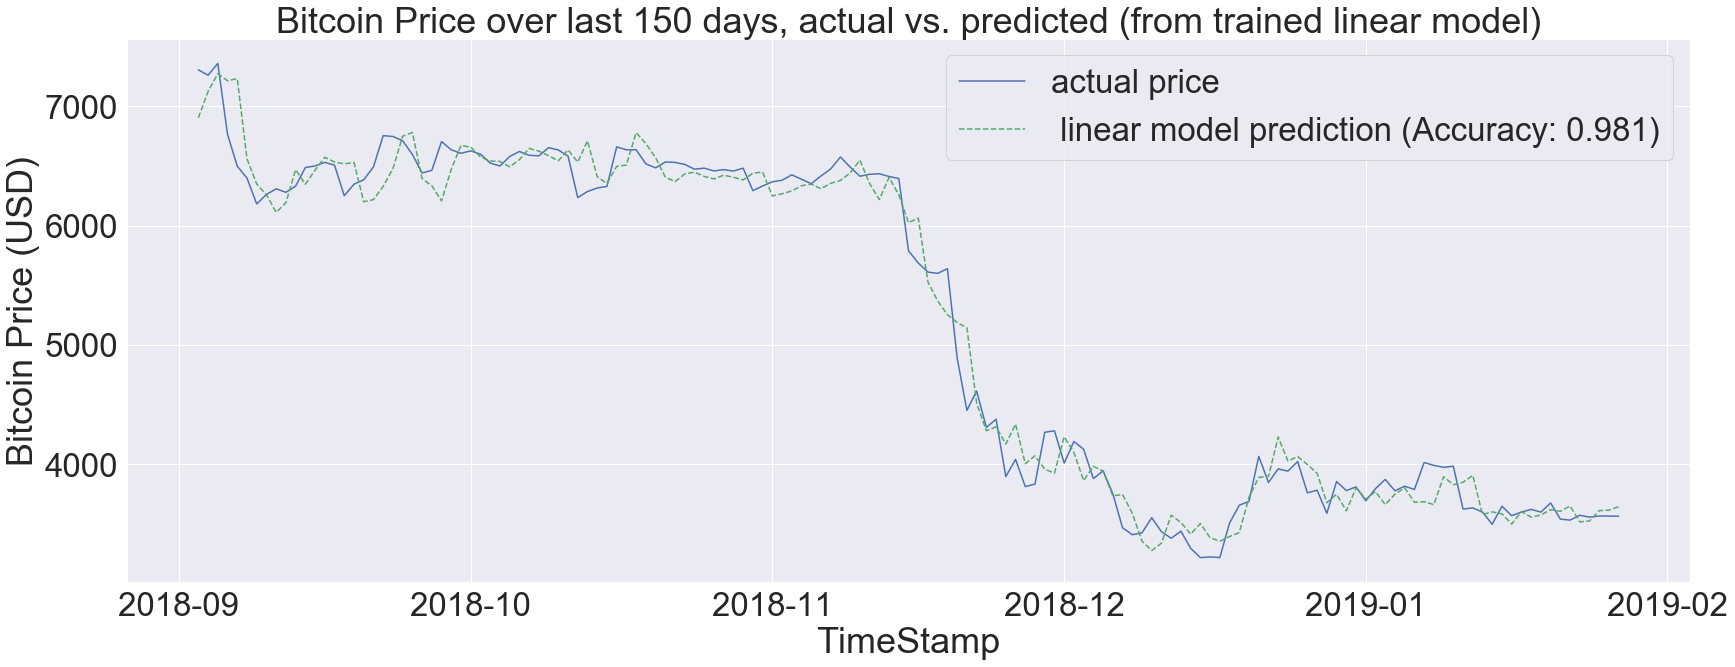

In [7]:
X_train = np.array(training_data[features_to_fit])
y_train = np.array(training_data[['bitcoin Price']])
sns.set(font_scale=3)

m_linear = LinearRegression()
m_linear.fit(X_train, y_train)
score_linear = m_linear.score(X_train, y_train)
y_pred = m_linear.predict(X_train)

X_axis = training_data['TimeStamp']
plt.figure(figsize = (28,10))
plt.plot(X_axis, y_train, label='actual price')
plt.plot(X_axis, y_pred, 'g--', label=' linear model prediction (Accuracy: {})'.format(round(score_linear, 3)))
plt.title('Bitcoin Price over last {} days, actual vs. predicted (from trained linear model)'.format(days))
plt.xlabel('TimeStamp')
plt.ylabel('Bitcoin Price (USD)')
plt.legend(loc='upper right')

### 7. Instantiate linear regression model with Ridge regularization and fit it on training data.

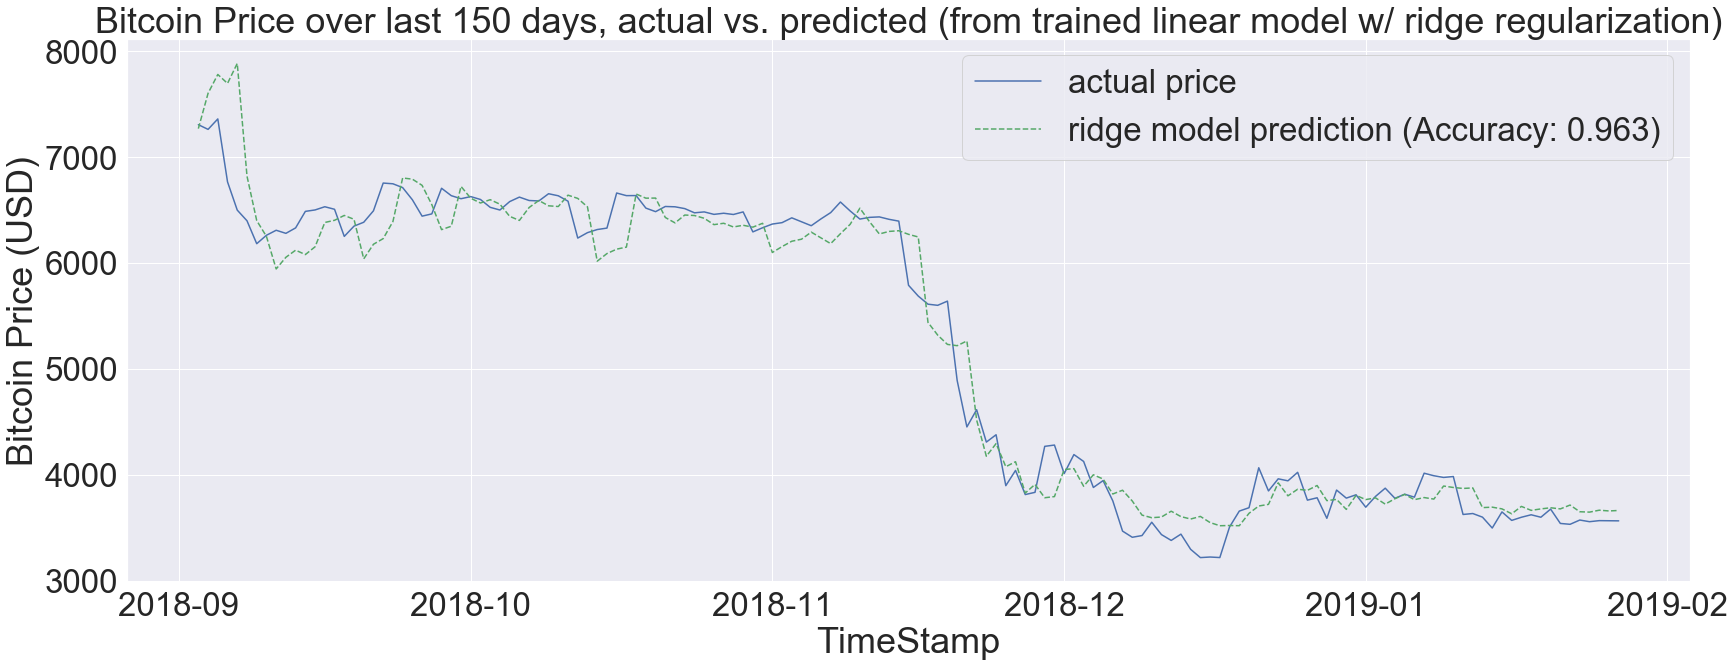

In [9]:
X_poly = PolynomialFeatures(degree=3).fit_transform(X_train)
m_ridge = Ridge(alpha = 0.5, solver='lsqr')
m_ridge.fit(X_poly, y_train)
score_ridge = m_ridge.score(X_poly, y_train)
y_pred_ridge = m_ridge.predict(X_poly)

plt.figure(figsize = (28,10))
plt.plot(X_axis, y_train, label='actual price')
plt.plot(X_axis, y_pred_ridge, 'g--', label='ridge model prediction (Accuracy: {})'.format(round(score_ridge, 3)))
plt.title('Bitcoin Price over last {} days, actual vs. predicted (from trained linear model w/ ridge regularization)'.format(days))
plt.xlabel('TimeStamp')
plt.ylabel('Bitcoin Price (USD)')
plt.legend(loc='upper right')

### 8. Instantiate linear regression model with Lasso regularization and fit it on training data.

/anaconda3/envs/dl/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


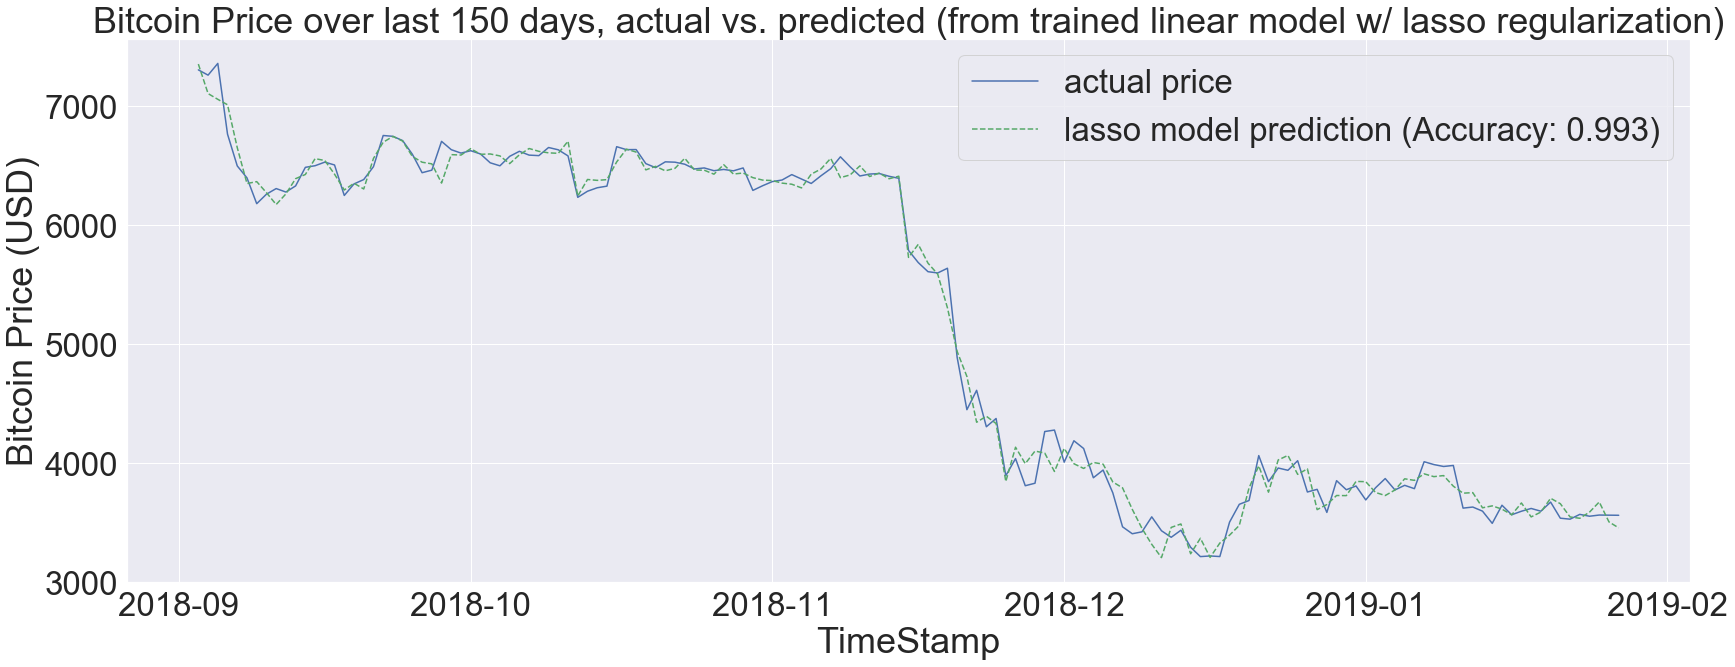

In [12]:
m_lasso = Lasso(alpha = 3.0, max_iter=3000)
m_lasso.fit(X_poly, y_train)
score_lasso = m_lasso.score(X_poly, y_train)
y_pred_lasso = m_lasso.predict(X_poly)

plt.figure(figsize = (28,10))
plt.plot(X_axis, y_train, label='actual price')
plt.plot(X_axis, y_pred_lasso, 'g--', label='lasso model prediction (Accuracy: {})'.format(round(score_lasso, 3)))
plt.title('Bitcoin Price over last {} days, actual vs. predicted (from trained linear model w/ lasso regularization)'.format(days))
plt.xlabel('TimeStamp')
plt.ylabel('Bitcoin Price (USD)')
plt.legend(loc='upper right')

### 9. Apply trained linear model on the testing data set to get predicted BTC prices for next 2 days.

In [13]:
testing_array = np.array(testing_data[features_to_fit])
btc_prediction = m_linear.predict(testing_array)
btc_prediction

array([[3637.61588334],
       [3632.53710295]])

In [14]:
testing_data_prediction = testing_data.copy()
testing_data_prediction['bitcoin Price'] = btc_prediction
testing_data_prediction

,TimeStamp,bitcoin Price,bitcoin Price - 2d,ethereum Price - 2d,ripple Price - 2d,bitcoin-cash Price - 2d,eos Price - 2d,stellar Price - 2d,litecoin Price - 2d,reddit_average_posts_48h - 2d,reddit_average_comments_48h - 2d,facebook_likes - 2d,twitter_followers - 2d,fb_likes_diff - 2d,tw_followers_diff - 2d
0,2019-01-28 18:00:00,3637.615883,3564.822417,0.148041,0.157457,0.087088,0.141892,0.027457,0.215656,0.420938,0.220323,0.998981,0.244473,0.216639,0.148383
1,2019-01-29 18:00:00,3632.537103,3563.614563,0.148925,0.153870,0.084928,0.138293,0.019724,0.220209,0.402693,0.214216,1.000000,0.244473,0.216639,0.165963


### The predicted Bitcoin prices can now be seen in the above DataFrame.